In [1]:
import zarrdataset as zds
import zarr

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = ["https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.4/idr0073A/9798462.zarr"]

In [3]:
import random
import numpy as np

# For reproducibility
np.random.seed(478963)
random.seed(478965)

In [4]:
z_img = zarr.open(filenames[0], mode="r")
z_img["0"].info

Name,/0
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 16433, 21115)"
Chunk shape,"(1, 1, 1, 1024, 1024)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,1040948385 (992.7M)
Chunks initialized,0/1071


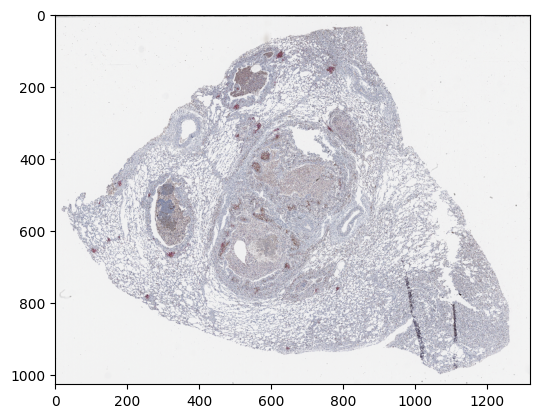

In [5]:
import matplotlib.pyplot as plt
plt.imshow(np.moveaxis(z_img["4"][0, :, 0], 0, -1))
plt.show()

In [6]:
mask = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
], dtype=bool)

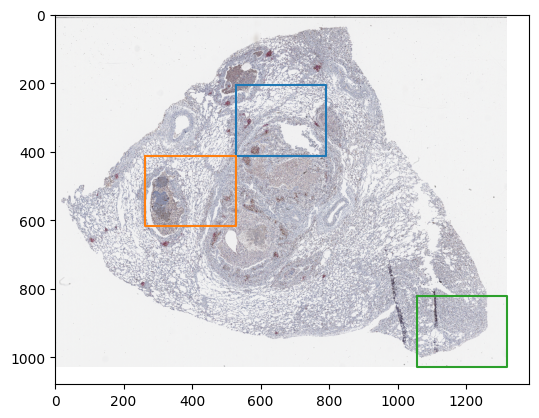

In [7]:
_, d, _, h, w = z_img["4"].shape
m_h, m_w = mask.shape

factor_h = h / m_h
factor_w = w / m_w

plt.imshow(np.moveaxis(z_img["4"][0, :, 0], 0, -1))

sampling_region = np.array([
    [0, 0],
    [0, factor_w],
    [factor_h, factor_w],
    [factor_h, 0],
    [0, 0]
])

for m_y, m_x in zip(*np.nonzero(mask)):
    offset_y = m_y * factor_h
    offset_x = m_x * factor_w
    plt.plot(sampling_region[:, 1] + offset_x,
             sampling_region[:, 0] + offset_y)

plt.show()

In [8]:
patch_size = dict(Y=512, X=512)
patch_sampler = zds.PatchSampler(patch_size=patch_size)

In [9]:
image_specs = zds.ImagesDatasetSpecs(
  filenames=filenames,
  data_group="0",
  source_axes="TCZYX",
)

# Use the MasksDatasetSpecs to add the specifications of the masks.
# Filenames can receive different types of variables, in this case a list with a single mask for the only image in image_specs.
masks_specs = zds.MasksDatasetSpecs(
  filenames=[mask],
  source_axes="YX",
)

my_dataset = zds.ZarrDataset([image_specs, masks_specs],
                             patch_sampler=patch_sampler,
                             draw_same_chunk=False,
                             shuffle=True)

In [10]:
ds_iterator = iter(my_dataset)

In [11]:
sample = next(ds_iterator)
type(sample), sample.shape, sample.dtype

(numpy.ndarray, (1, 3, 1, 512, 512), dtype('uint8'))

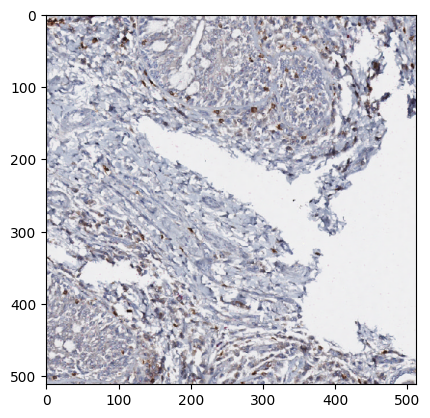

In [12]:
plt.imshow(np.moveaxis(sample[0, :, 0], 0, -1))
plt.show()

In [13]:
samples = []
for i, sample in enumerate(my_dataset):
    samples.append(np.pad(np.moveaxis(sample[0, :, 0], 0, -1),((1, 1), (1, 1), (0, 0))))

    # Obtain only 5 samples
    if i >= 4:
        break

grid_samples = np.hstack(samples)

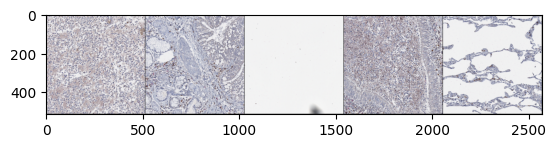

In [14]:
plt.imshow(grid_samples)
plt.show()